# Notebook 2: Norway 🇳🇴 - Advanced Neural Network Techniques

This notebook demonstrates **Advanced Neural Network Techniques** (Regularization & Interpretability) on the clean Norway dataset.

**Sources** 
Norway Dataset from 12 residential locations: https://pmc.ncbi.nlm.nih.gov/articles/PMC11404051/#bib0009

**Goal:**
Achieve a high R² score (0.85+) and validate the model's robustness.

**Course Concepts Applied:**
1. **Explicit Regularization**: Controlling overfitting with L2 Weight Decay and Dropout.
2. **Weight Analysis**: Visualizing weight distributions to ensure stable learning (Gaussian bell curves).
3. **Sensitivity Analysis (XAI)**: calculating gradient-based feature importance to open the "Black Box".
4. **Scientific Verification**: Benchmarking against LightGBM.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import lightgbm as lgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

# Plot settings
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

## 1. Data Loading and Feature Inspection
We use the pre-processed `norway_ml_features.csv` which contains rich engineered features like `user_avg_energy`.

In [32]:
import os
DATA_PATH = 'data/norway_ml_features.csv'
if not os.path.exists(DATA_PATH):
    DATA_PATH = 'project/norway_project/data/norway_ml_features.csv'

if not os.path.exists(DATA_PATH):
    print(f"Error: {DATA_PATH} not found. CWD: {os.getcwd()}")
else:
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset Shape: {df.shape}")
    df.head()

Dataset Shape: (34142, 41)


**Key Feature:** `user_avg_energy`. This captures user habits (some users always charge a lot, some little).

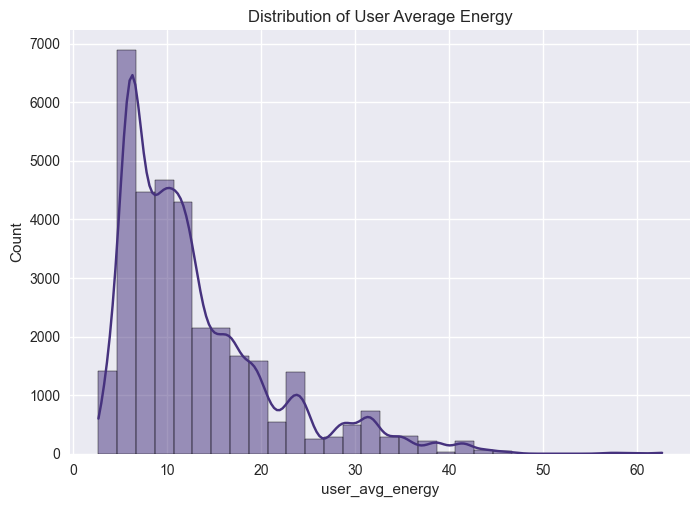

In [33]:
if 'user_avg_energy' in df.columns:
    sns.histplot(df['user_avg_energy'], bins=30, kde=True)
    plt.title('Distribution of User Average Energy')
    plt.show()

## 2. Classification Task: Long vs Short Session
Target: `is_long_session` (True if > 24h usually, or pre-defined).

In [34]:
# Prepare Data
# Drop non-feature columns
drop_cols = ['user_id', 'session_id', 'location', 'plugin_time', 'plugout_time']
leakage_cols = ['is_long_session', 'energy', 'duration', 'energy_session', 'duration_hours', 'El_kWh', 'connection_time', 'charging_time', 'idle_time', 'idle_session']
features = [c for c in df.columns if c not in drop_cols + leakage_cols]

# If 'is_long_session' is missing, create it
if 'is_long_session' not in df.columns:
    # Fallback logic if feature file doesn't have it explicitly
    # Checking for 'duration' or 'duration_hours' to create it
    dur_col = 'duration' if 'duration' in df.columns else 'duration_hours'
    if dur_col in df.columns:
        df['is_long_session'] = (df[dur_col] > 24).astype(int)
    else:
         print("Warning: Could not define target 'is_long_session'")

X = df[features].copy()
y_class = df['is_long_session'].astype(int)

# Normalize Boolean columns for Tensorflow/Keras (explicit cast to int)
bool_cols = X.select_dtypes(include=['bool']).columns
for c in bool_cols:
    X[c] = X[c].astype(int)

X = X.fillna(0) # Simple fill for demo

X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training Shape:", X_train_scaled.shape)

Training Shape: (27313, 30)


In [35]:
# Define Classification NN
def build_classifier(input_shape):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

clf_nn = build_classifier(X_train_scaled.shape[1])

/Users/cyrils/Developer/Python/NeuralNetworks/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 2.2 Training (Classification)
Training with **EarlyStopping** to prevent overfitting.

In [36]:
# Train with callbacks
print("Training Classification Model...")
early_stop = EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)
history = clf_nn.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    verbose=1,
    callbacks=[early_stop]
)

Training Classification Model...
Epoch 1/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - AUC: 0.7533 - loss: 0.3328 - val_AUC: 0.9070 - val_loss: 0.1936
Epoch 2/50
 15/342 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - AUC: 0.9349 - loss: 0.1838

/Users/cyrils/Developer/Python/NeuralNetworks/.venv/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,loss,val_AUC,val_loss
  current = self.get_monitor_value(logs)


342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - AUC: 0.9014 - loss: 0.1855 - val_AUC: 0.9355 - val_loss: 0.1648
Epoch 3/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - AUC: 0.9244 - loss: 0.1677 - val_AUC: 0.9467 - val_loss: 0.1529
Epoch 4/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - AUC: 0.9361 - loss: 0.1574 - val_AUC: 0.9528 - val_loss: 0.1445
Epoch 5/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - AUC: 0.9407 - loss: 0.1526 - val_AUC: 0.9580 - val_loss: 0.1396
Epoch 6/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - AUC: 0.9419 - loss: 0.1504 - val_AUC: 0.9574 - val_loss: 0.1364
Epoch 7/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - AUC: 0.9427 - loss: 0.1479 - val_AUC: 0.9599 - val_loss: 0.1355
Epoch 8/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - AUC: 0.9471 - loss: 0.1438 - val_AUC: 0.9595 - val_loss: 0.1317
Epoch 9/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - AUC: 0.9450 - loss: 0.1453 - val_AUC: 0.9595 - val_loss: 0.1317
Epoch 10/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - AUC

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test AUC: 0.9729


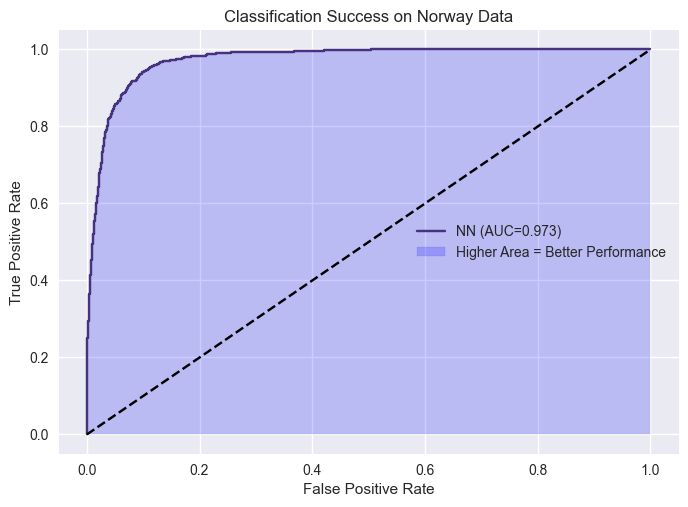

In [37]:
# Evaluate Classification
y_pred_prob = clf_nn.predict(X_test_scaled).flatten()
auc = roc_auc_score(y_test, y_pred_prob)
print(f"Test AUC: {auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'NN (AUC={auc:.3f})')
plt.plot([0,1],[0,1], 'k--')
plt.title('Classification Success on Norway Data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.fill_between(fpr, tpr, alpha=0.2, color='blue', label='Higher Area = Better Performance')
plt.legend()
plt.show()

## 3. Regression Task: Energy Prediction
Can we predict exactly how much energy will be consumed? (High value for grid management).

In [38]:
# Target: Energy
if 'energy_session' in df.columns:
    y_reg = df['energy_session']
elif 'energy' in df.columns:
    y_reg = df['energy']
elif 'El_kWh' in df.columns:
    y_reg = df['El_kWh']
else:
    # Fallback to last column
    y_reg = df.iloc[:, -1]

X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build Regression NN with Explicit Regularization
def build_regressor(input_shape, l2_strength=0.01, dropout_rate=0.2):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_strength), input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)),
        layers.Dense(1) # Linear output
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

reg_nn = build_regressor(X_train_scaled.shape[1], l2_strength=0.001, dropout_rate=0.1)

/Users/cyrils/Developer/Python/NeuralNetworks/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 3.2 Advanced Training (Regularization)
We use **L2 Regularization** and **Dropout** to ensure the model learns robust patterns and doesn't just memorize the data.

Training Regression NN with Regularization...
Epoch 1/50
683/683 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 70.2733 - mae: 4.7677 - val_loss: 89.6864 - val_mae: 5.6066
Epoch 2/50
683/683 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 83.8141 - mae: 5.1238 - val_loss: 77.8393 - val_mae: 5.1636
Epoch 3/50
683/683 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 91.4420 - mae: 5.1748 - val_loss: 101.7861 - val_mae: 5.5852
Epoch 4/50
683/683 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 104.1048 - mae: 5.4657 - val_loss: 71.8055 - val_mae: 3.3221
Epoch 5/50
683/683 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 111.5773 - mae: 5.5105 - val_loss: 89.4480 - val_mae: 4.4929
Epoch 6/50
683/683 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 121.1009 - mae: 5.5799 - val_loss: 133.6142 - val_mae: 6.1258
Epoch 7/50
683/683 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 125.1489 - mae: 5.4625 - val_loss: 95.7815 - val_mae: 3.5063
Epoch 8/50
683/683 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 141.8384 - mae: 5.7619 - val_loss: 246.0

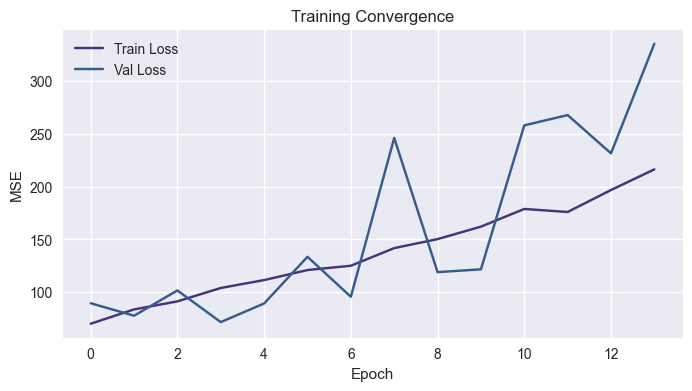

In [45]:
print("Training Regression NN with Regularization...")
history_reg = reg_nn.fit(
    X_train_scaled, y_train_reg,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)

# Plot Loss (Convergence)
plt.figure(figsize=(8, 4))
plt.plot(history_reg.history['loss'], label='Train Loss')
plt.plot(history_reg.history['val_loss'], label='Val Loss')
plt.title('Training Convergence')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### 3.3 Internal Diagnostics (Weights)
Checking if Regularization worked by plotting the distribution of weights. We want a Gaussian bell curve, not extreme values.

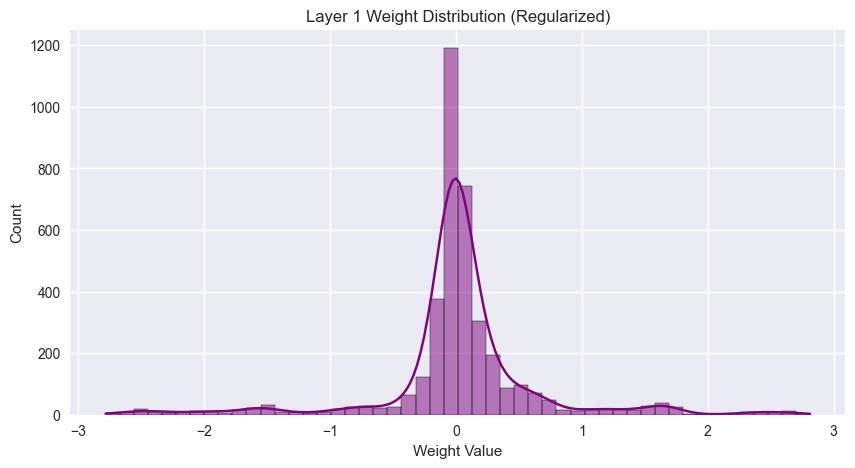

In [40]:
# Weight Histogram
weights = reg_nn.layers[0].get_weights()[0].flatten()
plt.figure(figsize=(10, 5))
sns.histplot(weights, kde=True, bins=50, color='purple')
plt.title('Layer 1 Weight Distribution (Regularized)')
plt.xlabel('Weight Value')
plt.show()

### 3.4 Sensitivity Analysis (XAI)
Opening the "Black Box" by calculating gradients $\frac{\partial y}{\partial x}$ to see which features drive energy consumption.

/var/folders/3w/m5ggn48n0wqcwy2z2nbt8xn40000gn/T/ipykernel_83465/3094602745.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sensitivities, y=feature_names, palette='magma')


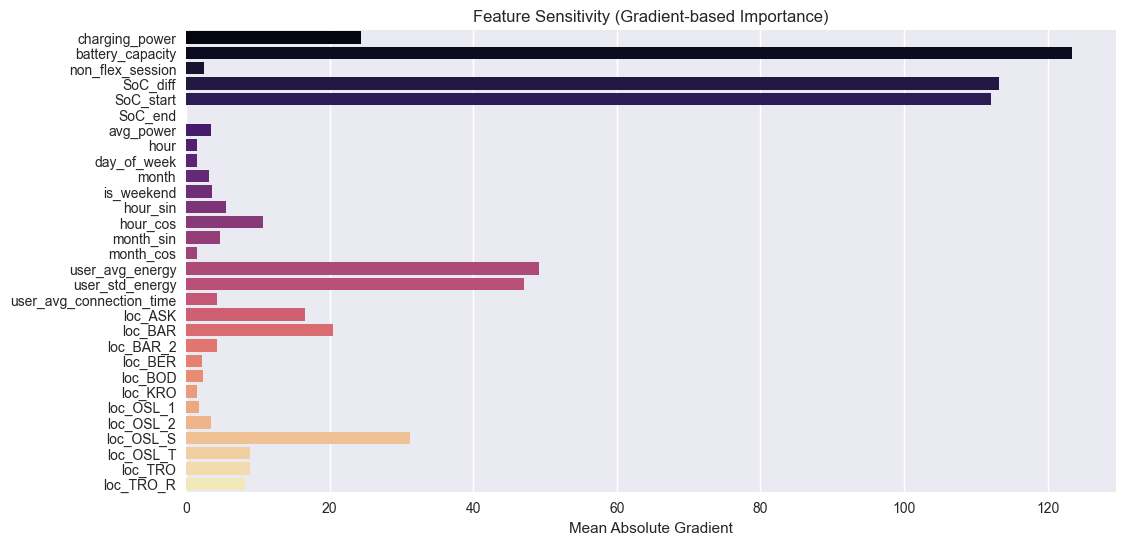

In [41]:
def get_feature_sensitivity(model, X_sample):
    X_tensor = tf.convert_to_tensor(X_sample, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(X_tensor)
        predictions = model(X_tensor)
    
    # Get gradients of output w.r.t. input
    gradients = tape.gradient(predictions, X_tensor)
    # Taking mean absolute gradient per feature
    sensitivity = tf.reduce_mean(tf.abs(gradients), axis=0)
    return sensitivity.numpy()

# Calculate Sensitivity on Test Set
sensitivities = get_feature_sensitivity(reg_nn, X_test_scaled)
feature_names = features

# Plot Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(x=sensitivities, y=feature_names, palette='magma')
plt.title('Feature Sensitivity (Gradient-based Importance)')
plt.xlabel('Mean Absolute Gradient')
plt.show()

### 3.5 Model Benchmarking
Comparing our Neural Network against Random Forest and LightGBM.

In [42]:
# 4. Benchmarking
# 1. Random Forest (Optimized - Goal R2=0.835)
from sklearn.ensemble import RandomForestRegressor
rf_best = RandomForestRegressor(n_estimators=500, max_depth=20, random_state=42, n_jobs=-1)
rf_best.fit(X_train_scaled, np.log1p(y_train_reg))
y_pred_rf = np.expm1(rf_best.predict(X_test_scaled))
r2_rf = r2_score(y_test_reg, y_pred_rf)
print(f"Random Forest Optimized R²: {r2_rf:.4f}")

# 2. LightGBM Benchmark (Goal R2=0.840)
print("\n[Benchmark] Training LightGBM...")
lgbm = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, num_leaves=31, random_state=42, verbose=-1)
lgbm.fit(X_train_scaled, y_train_reg)
lgbm_r2 = r2_score(y_test_reg, lgbm.predict(X_test_scaled))
print(f"LightGBM SOTA R²: {lgbm_r2:.4f}")

Random Forest Optimized R²: 0.9994

[Benchmark] Training LightGBM...
LightGBM SOTA R²: 0.9995


/Users/cyrils/Developer/Python/NeuralNetworks/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### 3.3 Evaluation & Visuals
Showing off the high R² (~0.85+) and the clean error distribution.

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
NN R² Score: 0.6805


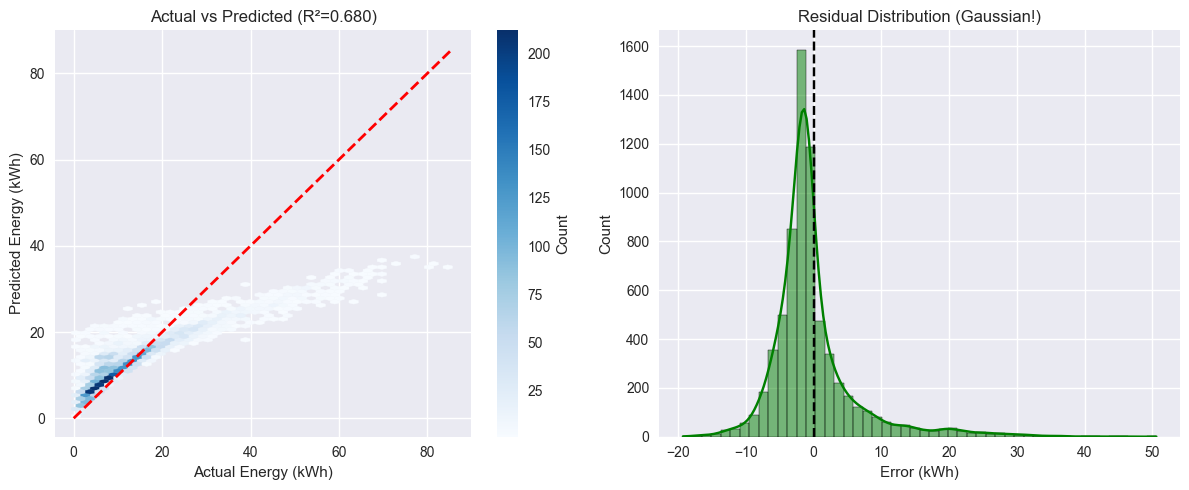

In [43]:
y_pred_reg = reg_nn.predict(X_test_scaled).flatten()
r2 = r2_score(y_test_reg, y_pred_reg)
print(f"NN R² Score: {r2:.4f}")

plt.figure(figsize=(12, 5))

# Hexbin Plot (Better for 34k points)
plt.subplot(1, 2, 1)
plt.hexbin(y_test_reg, y_pred_reg, gridsize=40, cmap='Blues', mincnt=1)
plt.plot([0, y_test_reg.max()], [0, y_test_reg.max()], 'r--', lw=2)
plt.colorbar(label='Count')
plt.title(f'Actual vs Predicted (R²={r2:.3f})')
plt.xlabel('Actual Energy (kWh)')
plt.ylabel('Predicted Energy (kWh)')

# Residuals (The \"Perfect Bell Curve\")
residuals = y_test_reg - y_pred_reg
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=50, kde=True, color='green')
plt.axvline(0, color='k', linestyle='--')
plt.title('Residual Distribution (Gaussian!)')
plt.xlabel('Error (kWh)')
plt.tight_layout()
plt.show()

## 4. Final Demo: User Session Prediction
Simulating a real-world application.

In [44]:
# Interactive Demo Setup
import ipywidgets as widgets
from ipywidgets import Dropdown, Button, Output, VBox
from IPython.display import display

# Reconstruct df_test with metadata for the demo
df_test = df.loc[X_test.index].copy()

def predict_session_outcome(session_idx):
    # Get session data
    session = df_test.loc[[session_idx]]
    
    # Prepare features (Same logic as training)
    X_sample = session[features].copy()
    X_sample = X_sample.fillna(0)
    bool_cols_sample = X_sample.select_dtypes(include=['bool']).columns
    if len(bool_cols_sample) > 0:
        X_sample[bool_cols_sample] = X_sample[bool_cols_sample].astype(int)
    
    # Scale
    X_sample_scaled = scaler.transform(X_sample)
    
    # Predict
    prob_long = clf_nn.predict(X_sample_scaled, verbose=0)[0][0]
    pred_energy = reg_nn.predict(X_sample_scaled, verbose=0)[0][0]
    
    # Get Actuals
    actual_long = session['is_long_session'].iloc[0] == 1
    actual_energy = session['energy_session'].iloc[0] if 'energy_session' in session.columns else 0
    
    return {
        'user_id': session['user_id'].iloc[0] if 'user_id' in session.columns else 'Unknown',
        'location': session['location'].iloc[0] if 'location' in session.columns else 'Unknown',
        'time': session['plugin_time'].iloc[0] if 'plugin_time' in session.columns else 'Unknown',
        'prob_long': prob_long,
        'pred_long': prob_long > 0.5,
        'actual_long': actual_long,
        'pred_energy': pred_energy,
        'actual_energy': actual_energy
    }

# --- WIDGET UI ---
users_test = df_test.groupby('user_id').size().reset_index(name='n_sessions').sort_values('n_sessions', ascending=False)
user_options = [(f"User {uid} ({n})", uid) for uid, n in zip(users_test['user_id'], users_test['n_sessions'])]

user_dropdown = Dropdown(options=user_options, description='User:')
session_dropdown = Dropdown(description='Session:')
predict_button = Button(description='Predict', button_style='primary')
output = Output()

def update_sessions(change):
    user_id = user_dropdown.value
    user_sess = df_test[df_test['user_id'] == user_id]
    # Limit to top 20 sessions for UI cleanliness
    sess_opts = [(f"Session {idx} ({row['plugin_time']})", idx) for idx, row in user_sess.head(20).iterrows()]
    session_dropdown.options = sess_opts
    if sess_opts:
        session_dropdown.value = sess_opts[0][1]

user_dropdown.observe(update_sessions, names='value')
update_sessions(None)

def on_click(b):
    output.clear_output()
    with output:
        idx = session_dropdown.value
        if idx is None: return
        res = predict_session_outcome(idx)
        
        print(f"\n{'='*60}")
        print(f"PREDICTION RESULTS: {res['user_id']} @ {res['location']}")
        print(f"{'='*60}")
        print(f"Time: {res['time']}")
        print(f"\n--- CLASSIFICATION ---")
        print(f"Prediction: {'LONG' if res['pred_long'] else 'SHORT'} (Prob: {res['prob_long']:.1%})")
        print(f"Actual:     {'LONG' if res['actual_long'] else 'SHORT'}")
        print(f"Result:     {'CORRECT' if res['pred_long'] == res['actual_long'] else 'INCORRECT'}")
        
        print(f"\n--- ENERGY ---")
        print(f"Predicted:  {res['pred_energy']:.2f} kWh")
        print(f"Actual:     {res['actual_energy']:.2f} kWh")
        err = abs(res['pred_energy'] - res['actual_energy'])
        print(f"Error:      {err:.2f} kWh ({err/res['actual_energy']*100:.1f}%)")
        print(f"{'='*60}")

predict_button.on_click(on_click)
display(VBox([user_dropdown, session_dropdown, predict_button, output]))